In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [21]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/GTCAP Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

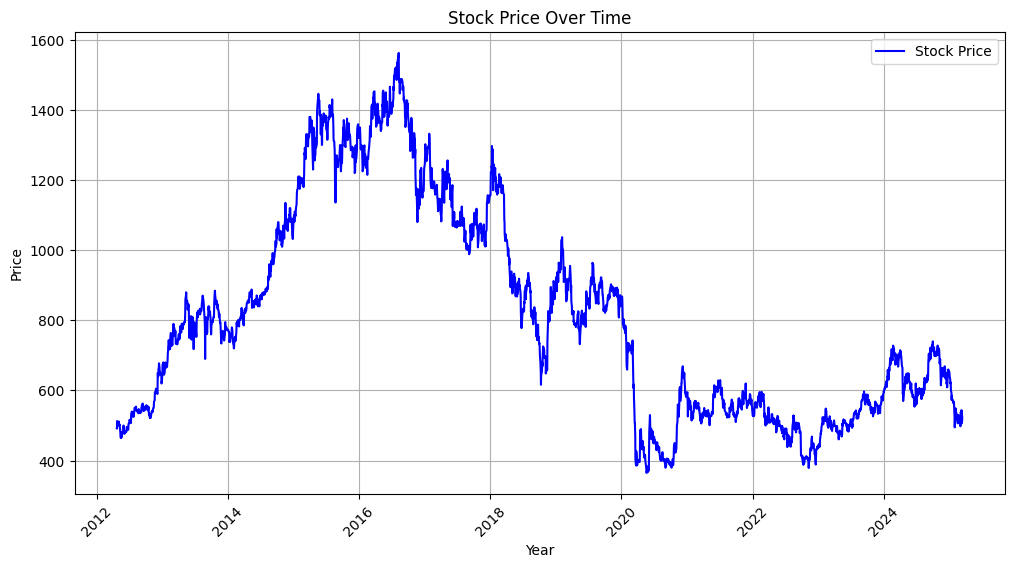

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

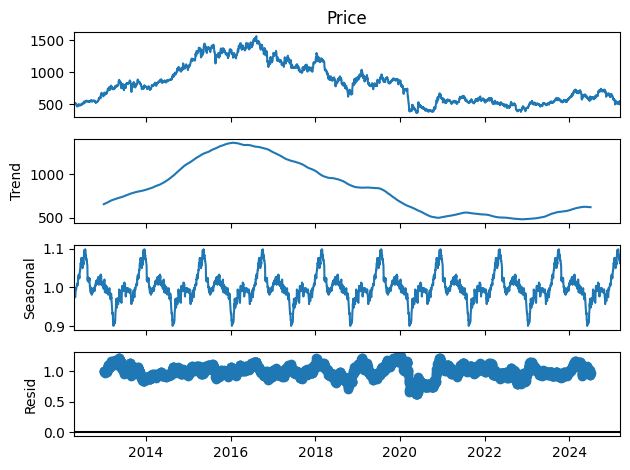

In [23]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [24]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [25]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [26]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [27]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [28]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("GTCAP_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [30]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0069

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 250s 95ms/step - loss: 0.0069 - val_loss: 1.4697e-04
Epoch 2/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 250s 96ms/step - loss: 0.0020 - val_loss: 4.9674e-04
Epoch 3/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 246s 94ms/step - loss: 0.0015 - val_loss: 3.1218e-04
Epoch 4/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 246s 95ms/step - loss: 0.0015 - val_loss: 1.6627e-04
Epoch 5/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0013

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 248s 95ms/step - loss: 0.0013 - val_loss: 1.2615e-04
Epoch 6/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 262s 95ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 7/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 248s 95ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 248s 95ms/step - loss: 0.0010 - val_loss: 1.8187e-04
Epoch 9/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 247s 95ms/step - loss: 0.0010 - val_loss: 9.5343e-04
Epoch 10/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 9.8365e-04

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 251s 96ms/step - loss: 9.8364e-04 - val_loss: 1.1440e-04
Epoch 11/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0010

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 259s 95ms/step - loss: 0.0010 - val_loss: 9.4772e-05
Epoch 12/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 8.8946e-04

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 248s 95ms/step - loss: 8.8945e-04 - val_loss: 9.0222e-05
Epoch 13/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 262s 95ms/step - loss: 7.8860e-04 - val_loss: 9.8751e-05
Epoch 14/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 252s 97ms/step - loss: 8.9623e-04 - val_loss: 1.0244e-04
Epoch 15/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 272s 104ms/step - loss: 8.2595e-04 - val_loss: 9.0800e-05
Epoch 16/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 306s 98ms/step - loss: 7.2970e-04 - val_loss: 2.1544e-04
Epoch 17/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.8673e-04

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 254s 98ms/step - loss: 6.8673e-04 - val_loss: 8.7029e-05
Epoch 18/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.5657e-04

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 250s 96ms/step - loss: 6.5657e-04 - val_loss: 8.1180e-05
Epoch 19/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 7.1484e-04

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 248s 95ms/step - loss: 7.1483e-04 - val_loss: 7.8230e-05
Epoch 20/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 252s 97ms/step - loss: 6.0044e-04 - val_loss: 1.1844e-04
Epoch 21/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 253s 97ms/step - loss: 6.8164e-04 - val_loss: 1.1198e-04
Epoch 22/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 248s 95ms/step - loss: 6.7330e-04 - val_loss: 1.4567e-04
Epoch 23/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.3081e-04

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 254s 98ms/step - loss: 6.3081e-04 - val_loss: 7.4004e-05
Epoch 24/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 249s 96ms/step - loss: 6.3748e-04 - val_loss: 8.7405e-05
Epoch 25/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 255s 98ms/step - loss: 6.0806e-04 - val_loss: 1.6045e-04
Epoch 26/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 250s 96ms/step - loss: 6.2519e-04 - val_loss: 6.5903e-04
Epoch 27/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 252s 97ms/step - loss: 5.5512e-04 - val_loss: 1.0394e-04
Epoch 28/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 249s 96ms/step - loss: 5.2681e-04 - val_loss: 9.6500e-05


In [31]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("GTCAP_Model.h5")

In [32]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [33]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [34]:
actual_recent = df.tail(23)

In [35]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

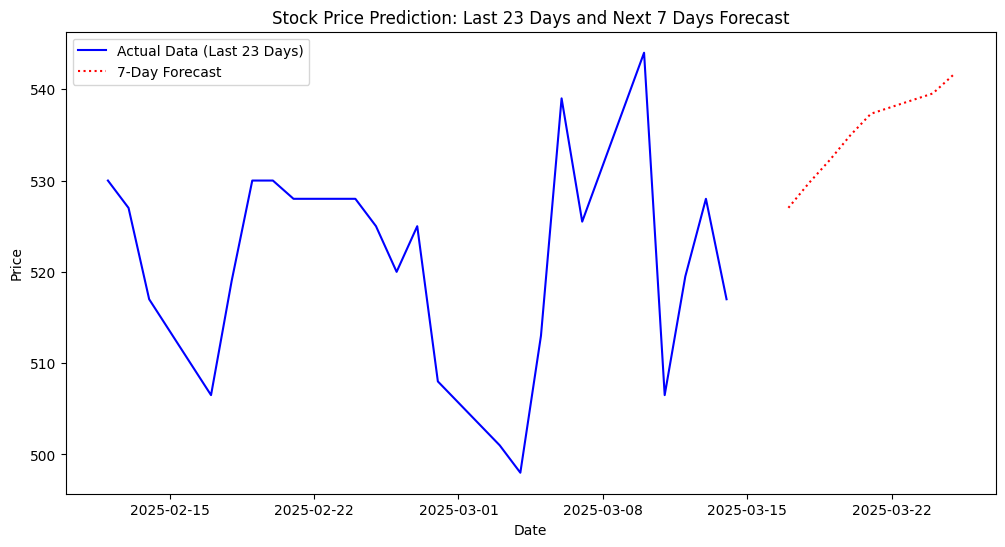

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [37]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [38]:
forecast_df.to_csv('GTCAP_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
